# Mapping the sRGB gamut
---
This notebook is part 2/5 of a tutorial based on the [```colourspace```](https://github.com/gillesferrand/colourspace) package.

Here we map the maximum gamut that standard RGB displays can produce, using the ```gamut``` module.

In [1]:
from colourspace import gamut

convertor = ' custom '


The sRGB gamut is readily defined in its native RGB space: it is the RGB cube with coordinates ranging from 0 to 1. We need to know its boundary in perceptual colour spaces, so that we can design colours that can actually be displayed. In the LCH space, both L and H are bounded, so the question is knowing the maximal C that is possible for a given L and H. <br>There is generically two ways of determining the surface Cmax(L,H):<br>
(1) Discretize the LH plane, for each point find the max possible C, to do so convert the LCH colour to sRGB and check whether it is within the gamut (since LCH is the design space and RGB the target space, I call this the "forward" method);<br>
(2) Get the contour points of the sRGB gamut in the RGB space where it is naturally defined,  convert these points back to LCH space, and interpolate the implicit function C(L,H) on a grid (I call this the "backward" method).

In [2]:
%matplotlib inline

In [3]:
figsize = (12,12/3.6)

## Forward method: discretize in LCH

The function ```find_Cmax_forward(res,gamut)``` locates the Cmax for each point over the LH plane, discretized at (uniform) resolution ```res```, for the chosen gamut ```gamut='sRGB'|'full'```. Parameter ```res``` is defined as the number of points per unit L or H, so that ```res=1``` produces a 101×361 map. In this notebook we are looking at the sRGB gamut only, the "full" gamut is the topic of the next notebook. The resulting array Cmax is stored in dictionnary ```Cmax[res][gamut]```, and optionaly written to disk and displayed on screen. Internally the function may use different methods, either locating the Cmax for a given L,H pair by dichotomy, or mapping the entire C range and checking until where it's valid. The condition for being in the gamut is given by the function ```valid_LCH_sRGB(LCH)```, that simply converts a LCH triplet to RGB and checks if the values are in [0,1]

In [4]:
print gamut.valid_LCH_sRGB(50,100,310)
print gamut.valid_LCH_sRGB(50,100,200)

True
False


In [5]:
for Cres in [1., 0.1, 0.01]:
    print gamut.find_Cmax_for_LH(50,200,Cres,'sRGB')

30.0
30.4
30.38


In [6]:
%time gamut.find_Cmax_forward(1,'sRGB',save=False,plot=False)
print gamut.Cmax[1]['sRGB'].shape

CPU times: user 12.1 s, sys: 77.4 ms, total: 12.1 s
Wall time: 12.2 s
(101, 361)


In [7]:
%time gamut.find_Cmax_forward(2,'sRGB',save=False,plot=False)
print gamut.Cmax[1]['sRGB'].shape

CPU times: user 55.5 s, sys: 344 ms, total: 55.8 s
Wall time: 56.5 s
(101, 361)


In [8]:
print gamut.get_extremum(1,'sRGB')
print gamut.get_extremum(2,'sRGB')

[  33.  132.  306.]
[  32.5        132.3999939  306.5      ]


The function ```plot_Cmax(res,gamut)``` plots Cmax, colour-mapped as a geyscale image (and writes it as a png file, the entire figure and/or the bare image).

writing /Users/gferrand/simus/colour/colourspace/gamut/Cmax_res1_sRGB_axon.png
writing /Users/gferrand/simus/colour/colourspace/gamut/Cmax_res1_sRGB_axoff.png


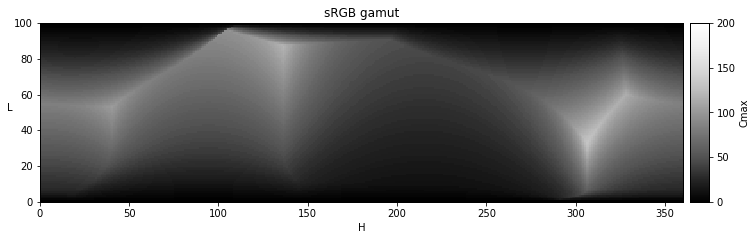

In [9]:
gamut.plot_Cmax(1,'sRGB',figsize=figsize)

writing /Users/gferrand/simus/colour/colourspace/gamut/Cmax_res2_sRGB_axon.png
writing /Users/gferrand/simus/colour/colourspace/gamut/Cmax_res2_sRGB_axoff.png


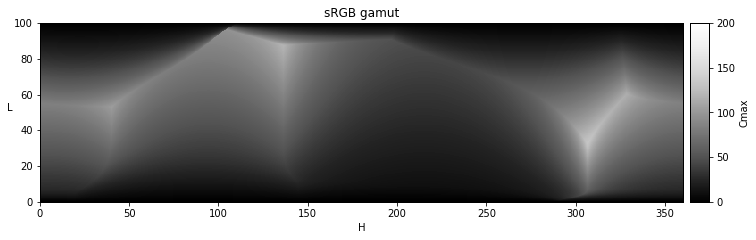

In [10]:
gamut.plot_Cmax(2,'sRGB',figsize=figsize)

Note that a grayscale image has 8-bit depth, that is 256 levels, so at ```res=1``` Cmax is perfectly represented by this image. At higher resolutions some details get visibly finer (e.g. the upper-left edge), but the precision gained in the value of C can barely be appreciated on the image.

The gamut (= a 2D array) can be saved/loaded from/to the ```Cmax[res][gamut]``` dictionnary <br>
\- as a NumPy binary file with ```save_Cmax_npy(res,gamut)``` / ```load_Cmax_npy(res,gamut)```<br>
\- as a plain text file with ```save_Cmax_txt(res,gamut)``` / ```load_Cmax_txt(res,gamut)```

The pre-computed gamut is provided at resolutions ```res=1``` and ```res=10```.

## Backward method: discretize in RGB

The boundary of the sRGB gamut is readily described in RGB space, as the edges of the [0,1]^3 cube.<br>
The function ```get_RGB_faces()``` samples the six faces with a given number of points per coordinate (it does it face by face, so there is redundancy at the edges and vertices).

600  points


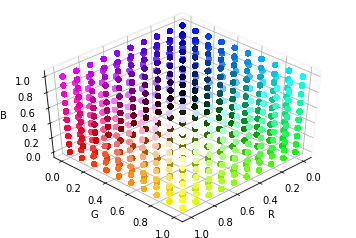

In [11]:
RGB_list = gamut.get_RGB_faces(num=10)
gamut.plot3D(RGB_list,angle=(45,45),figsize=(6,4))

The function ```get_edges_LCH_sRGB()``` converts these points to LCH space. The set of points implicitly defines a function C(L,H). This can be visualized with the helper function ```plot2D()``` that relies on Matplotlib's ```tricontourf()```. Each dot marks a colour sampled from the RGB cube faces, the greyscale contours code the interpolated value of C.

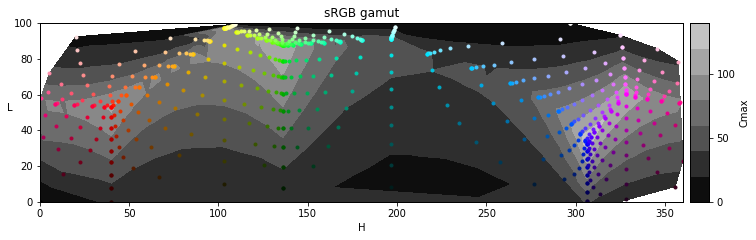

In [12]:
LCH_max = gamut.get_edges_LCH['sRGB'](10)
gamut.plot2D(LCH_max,marker='.',colour='',name='sRGB',figsize=figsize,dir='')

Note that, while this method is simple, we don't control the resolution in LCH.
The function ```find_Cmax_backward(res_native,res_LH,gamut)``` takes this and re-interpolates Cmax(L,H) on a regular grid, using ```scipy.interpolate.griddata```. Here ```res_native``` designates the resolution in the space where the gamut is defined (in our case RGB), while ```res_LH``` designates the (uniform) resolution in the LCH space. 

CPU times: user 21.6 ms, sys: 4.65 ms, total: 26.3 ms
Wall time: 18.6 ms
writing /Users/gferrand/simus/colour/colourspace/gamut/Cmax_res1_sRGB_axon.png
writing /Users/gferrand/simus/colour/colourspace/gamut/Cmax_res1_sRGB_axoff.png


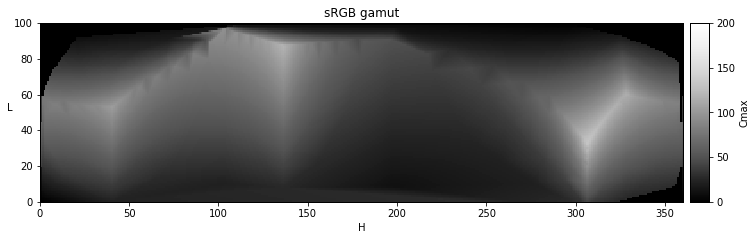

In [13]:
%time gamut.find_Cmax_backward(10, 1, 'sRGB', save=False, plot=False)
gamut.plot_Cmax(1,'sRGB',figsize=figsize)

CPU times: user 909 ms, sys: 75.1 ms, total: 984 ms
Wall time: 679 ms
writing /Users/gferrand/simus/colour/colourspace/gamut/Cmax_res1_sRGB_axon.png
writing /Users/gferrand/simus/colour/colourspace/gamut/Cmax_res1_sRGB_axoff.png


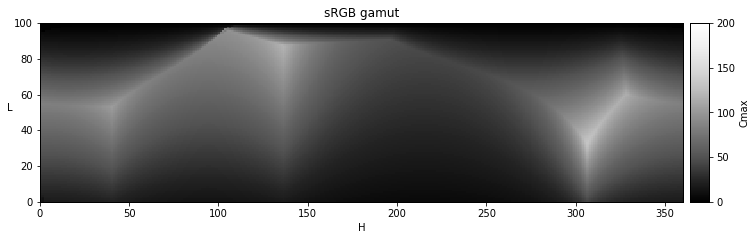

In [14]:
%time gamut.find_Cmax_backward(100, 1, 'sRGB', save=False, plot=False)
gamut.plot_Cmax(1,'sRGB',figsize=figsize)

We recover almost the same shape as before in LCH, when the resolution is high enough in RGB.

## Using the discretized gamut

The function ```set_Cmax(res,gamut)``` loads a gamut from disk, if the file is found, or computes it using the forward method.

In [15]:
res = 10
gamut.set_Cmax(res,'sRGB')

loading gamut from /Users/gferrand/simus/colour/colourspace/gamut/Cmax_res10_sRGB.npy


To get Cmax as a function of any (L,H), we can do a simple bi-linear interpolation. This is done by ```Cmax_for_LH(L,H,res,gamut)```, which will play a key role when generating slices and maps in the subsequent notebooks.

In [16]:
gamut.Cmax_for_LH(50,200,res,'sRGB')

array(30.399999618530273)

In [17]:
from colourspace import convert
import pylab as plt

Revisiting our first example of image making (note that ```Cmax_for_LH()``` is vectorized, as the conversion functions):

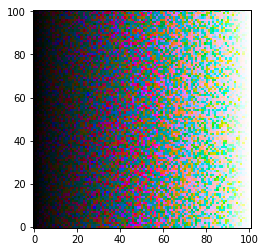

In [18]:
nx = 101
ny = 101
L = np.tile(np.linspace(0,100,nx),(ny,1))
H = 360*np.random.rand(nx,ny)
C = gamut.Cmax_for_LH(L,H,res,'sRGB') # max possible C
RGB = convert.clip3(convert.LCH2RGB(L,C,H))
plt.imshow(RGB,origin='lower')

Finally, we note that this gamut limitation comes from the display. Some displays have larger gamut than sRGB (e.g. DCI-P3). What is the largest possible gamut? This is defined by the human eye+brain system, and is explored in the next notebook.

---

<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img align="left" alt="Creative Commons License" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br>
<br>Gilles Ferrand
<br>2019-12-24